In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

from jsm_routines import SHMF, CSMF, SHMR, scatter_stat
import galhalo
import os

>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Tabulating sigma(M,z=0) ...
    From now on, sigma(M,z) is computed by interpolation.
>>> Tabulating z(W) and z(t_lkbk)...
>>> Preparing output redshifts for merger trees ...
    Number of output redshifts =  354, up to z = 20.06
>>> Tabulating Parkinson+08 J(u_res) ...
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...


In [38]:
as_data = np.load("../../data/12_4_0/numpy/acc_surv_mass.npy")
as_red = np.load("../../data/12_4_0/numpy/acc_surv_redshift.npy")

as_data[:, 0] = 0.0  # removing the host mass from the matrix
zero_mask = as_data != 0.0 #masking the padding!
Mh = np.log10(np.where(zero_mask, as_data, np.nan)) #switching the to nans!

max_real = Mh.shape[1] - np.sum(np.isnan(Mh),axis=1) # counting the maximum # of real subhalos in all realizations
int = min(max_real)
Mh = Mh[:, 1:int]

np.save("../figures/Mh_clean.npy", Mh)

In [39]:
Mh = np.load("../figures/Mh_clean.npy")

### Investigating the rank ordered subhalo mass distribution

In [40]:
def mass_rank(mass):

    rank = np.flip(np.argsort(mass,axis=1), axis=1) # rank the subhalos from largest to smallest

    ranked_mass = np.take_along_axis(mass, rank, axis=1) # this is it!!!

    return rank, ranked_mass
    

In [41]:
rank, sort = mass_rank(Mh)

In [37]:
np.sum(np.isnan(sort[:,0]))

3128

In [8]:
ave = np.nanmean(Mh, axis=0) #some standard statistics
std = np.nanstd(Mh, axis=0)
Nrank = ave.shape[0]

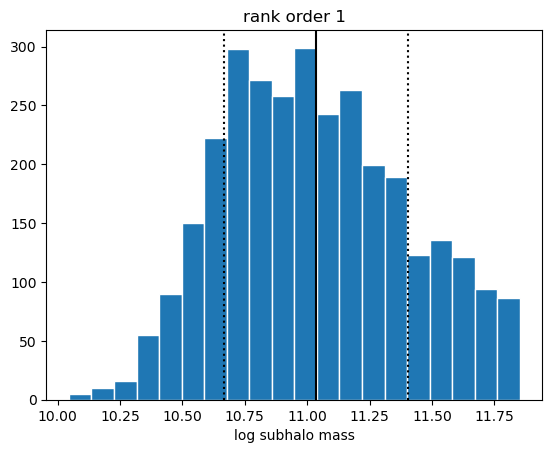

In [9]:
i = 0
plt.title("rank order "+str(i+1))
plt.axvline(ave[i], color="black")
plt.axvline(ave[i]+std[i], ls=":", color="black")
plt.axvline(ave[i]-std[i], ls=":", color="black")
plt.hist(Mh[:,i], bins=20, edgecolor="white")
plt.xlabel("log subhalo mass")
plt.show()

### Now working in stellar mass

In [10]:
as_data_s = galhalo.lgMs_D22_det(np.log10(as_data))

rank_s, sorted = mass_rank(as_data_s)
sorted[:, 0] = -np.inf  # removing the host mass from the matrix
zero_mask = ~np.isinf(sorted) #masking the padding!
Ms = np.where(zero_mask, sorted, np.nan) #switching the to nans!

max_real = Ms.shape[1] - np.sum(np.isnan(Ms),axis=1) # counting the maximum # of real subhalos in all realizations
int = max(max_real)
Ms = Ms[:, 1:int]

/var/folders/91/ygwd64w5659_623tzhx80kbc0000gn/T/ipykernel_29406/4180047193.py:1: RuntimeWarning: divide by zero encountered in log10
  as_data_s = galhalo.lgMs_D22_det(np.log10(as_data))


In [11]:
np.sum(np.isnan(Ms[0,:]))

97

In [12]:
det_ave = np.nanmean(Ms, axis=0) #some standard statistics
det_std = np.nanstd(Ms, axis=0)

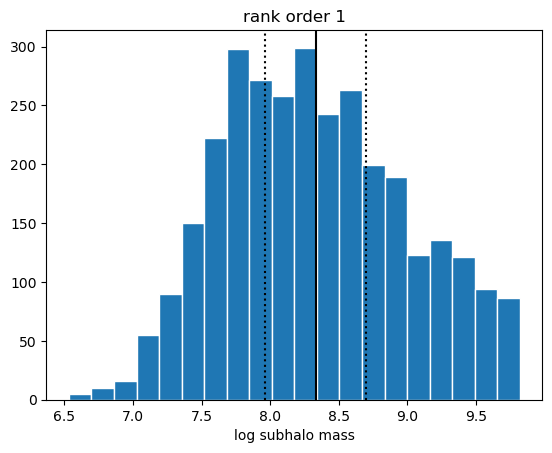

In [13]:
i = 0
plt.title("rank order "+str(i+1))
plt.axvline(det_ave[i], color="black")
plt.axvline(det_ave[i]+std[i], ls=":", color="black")
plt.axvline(det_ave[i]-std[i], ls=":", color="black")
plt.hist(Ms[:,i], bins=20, edgecolor="white")
plt.xlabel("log subhalo mass")
plt.show()

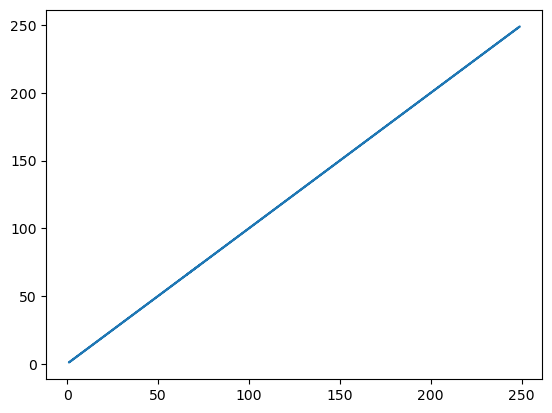

In [14]:
plt.plot(rank_h[:,1], rank_s[:,1])
plt.show()

### now trying an array of scatter values for several samples

In [15]:
mat = np.load("../figures/4D.npy")

In [16]:
across_samp = np.average(mat, axis=3)

In [17]:
example = across_samp[5]

In [18]:
yeet, yah = mass_rank(example)

In [25]:
np.flip(np.sort(example, axis=1))

array([[       nan,        nan,        nan, ..., 3.09454756, 3.07600216,
        3.07493248],
       [       nan,        nan,        nan, ..., 3.10694562, 3.09515709,
        3.0708616 ],
       [       nan,        nan,        nan, ..., 3.13401177, 3.11751653,
        3.09608146],
       ...,
       [       nan,        nan,        nan, ..., 3.11991697, 3.09810221,
        3.09382571],
       [       nan,        nan,        nan, ..., 3.08838978, 3.08249621,
        3.08117393],
       [       nan,        nan,        nan, ..., 3.14282045, 3.10078049,
        3.09998348]])

In [26]:
np.flip(np.sort(example, axis=1),axis=1)

array([[       nan,        nan,        nan, ..., 3.14282045, 3.10078049,
        3.09998348],
       [       nan,        nan,        nan, ..., 3.08838978, 3.08249621,
        3.08117393],
       [       nan,        nan,        nan, ..., 3.11991697, 3.09810221,
        3.09382571],
       ...,
       [       nan,        nan,        nan, ..., 3.13401177, 3.11751653,
        3.09608146],
       [       nan,        nan,        nan, ..., 3.10694562, 3.09515709,
        3.0708616 ],
       [       nan,        nan,        nan, ..., 3.09454756, 3.07600216,
        3.07493248]])

In [27]:
example

array([[3.20510475, 4.16187379, 4.66061589, ...,        nan,        nan,
               nan],
       [3.08838978, 3.8952339 , 3.33167339, ...,        nan,        nan,
               nan],
       [4.71671337, 4.15374583, 4.21429051, ...,        nan,        nan,
               nan],
       ...,
       [6.22405282, 4.39000737, 5.08412873, ...,        nan,        nan,
               nan],
       [3.200426  , 5.06659721, 3.97065613, ...,        nan,        nan,
               nan],
       [3.65412199, 3.18093293, 3.17778945, ...,        nan,        nan,
               nan]])